SPARK =>  is a distributed data processing engine with its components working collaboratively on a cluster of machines.

Spark Core & Spark SQL Engine:

- Spark SQL (DataFrames + Datasets)

- Spark Streaming (Structured Streaming)

- Machine Learning => MLlib

- Graph Processing Graph X



SPARK ARCHITECTURE:
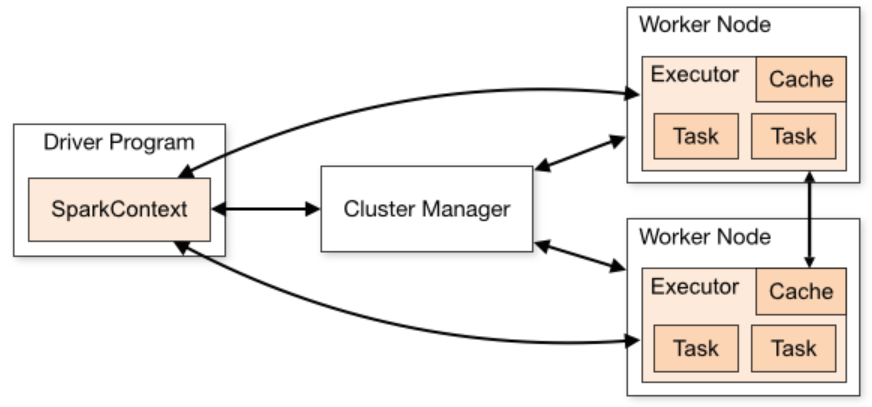

1) DRIVER PROGRAM -> is responsible for orchestrating parallel operations on the Spark cluster; the driver accesses the         distributed components in the cluster—the SPARK EXECUTORS and CLUSTER MANAGER — through a SPARKSESSION; it communicates with the cluster manager; it requests resources (CPU, memory, etc.) from the cluster manager for Spark’s executors (JVMs); once the resources are allocated, it communicates directly with the executors; 
the Driver is a process that executes the main program of Spark application and creates the SparkContext that coordinates the execution of jobs

2) SPARKSESSION - a connector to all Spark operations and data; provides a single unified entry point to all of Spark’s functionality (e.g. creating JVM runtime parameters, creating DF and Datasets, reading from datasources, accessing catalog metadata or issuing SQL queries); In an interactive Spark shell, the Spark driver instantiates a SparkSession, while in a Spark application, a SparkSession is created by the user; its a new entry point introduced with Spark 2. and it combines all functionalities available in the previously released contexts (SparkContext, SQLContext, HiveContext)

3) CLUSTER MANAGER - is responsible for managing and allocating resources for the cluster of nodes on which Spark application runs; currently exists 4 cluster managers : standalone cluster manager, Apache Hadoop YARN, Apache Mesos, Kubernetes

4) SPARK EXECUTOR - runs on each worker node in the cluster; the executors communicate with the driver program and are responsible for executing tasks on the workers; in most deployments modes, only a single executor runs per node


Data is distributed as partitions across the clusters, each partition Spark treats as a DataFrame in memory; partitioning allows for efficient parallelism - it allows Spark Executors to process only data that is close to them.

The transformations (e.g. select(), filter(), join(), orderBy(), groupBy()) and actions (e.g. show(), take(), count(), collect(), save()) contribute to a Spark query plan, nothing in a query plan is executed until an action is invoked. The action is what triggers the execution of all transformations recorded as part of the query execution plan.

Transformations - executed by Spark lazily -> A huge advantage of the lazy evaluation scheme is that Spark can inspect your computational query and optimize it by: joining or pipelining some operations and assigning them to a stage, or breaking them into stages by determining which operations require a shuffle or exchange of data across clusters.


API's  - when computing a result the same execution engine is used, independent of which API/language is using to express the computation:

1) RDD = Resilient Distributed Dataset => Low Level API

It is the collection of objects which is capable of storing the data partitioned across the multiple nodes of the cluster and also allows them to do processing in parallel; without any schema

3 ways of creation:

    * Parallelizing an existing collection of data
    
    * Referencing to the external data file stored
    
    * Creating RDD from an already existing RDD


2) DataFrame => High Level API

Spark Dataframes are the distributed collection of the data points, but here, the data is organized into the named columns;
allows to debug the code during the runtime (its not possible in case of RDD) 

3) DataSet => High Level API

High Level API -> limits the ability to instruct the compiler or control how their queries should be computed





SPARK UI -> localhost:4040

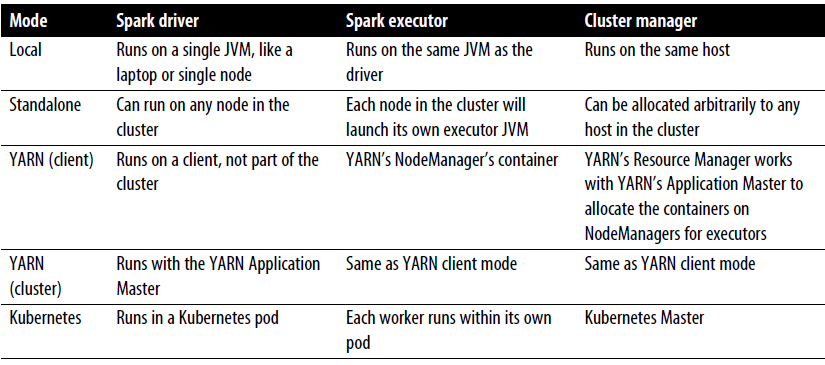




DATAFRAMES:
SCHEMA DEFINITION:

BENEFITS:
schema definition allows to prevent Spark from creating a separate job just to read a large portion of file to ascertain the schema, which for a large data file can be expensive and time-consuming; errors might be detected early if data doesn't match the schema.


MANAGED vs UNMANAGED TABLES:

- managed - both the metadata and the data in the file store are managed by Spark (local filesystem, HDFS, Amazon S3, Azure Blob); with query 'DROP TABLE' Spark will remove the metadata as well as the data
- unmanaged - Spark only manages the metadata, while you manage the data yourself in an external data source (e.g. Cassandra); with query 'DROP TABLE' Spark will remove only the metadata not the actual data

VIEWS:

 - global - visible across all SparkSessions on a given cluster => global_temp MUST BE ADDED BEFORE THE NAME OF GLOBAL VIEW
 
 - session-scoped - visible only to a single SparkSession (disappears after spark application is terminated)
 
 
CATALOG -> contains METADATA

UDF:

Pandas UDF -> implemented due to slower performance of the PySpark UDF comparing to Scala UDF (PySpark UDFs required data movement between the JVM and Python, which was quite expensive)

In [57]:
from pyspark.sql import SparkSession

spark=SparkSession.Builder().appName('LS').getOrCreate()

spark.sparkContext.setLogLevel("WARN")
spark



In [2]:
# accessing SparkContext within active SparkSession:

# sc=spark._sc
# or
sc=spark.sparkContext

In [3]:
# LOW LEVEL API - RDD creation:
from pyspark import SparkContext

# in pyspark shell sc variable is created automatically
#sc = SparkContext(appName = "testRDD")

# parallelizing data collection:
dane= [1,3,5,8,5,2]
rdd=sc.parallelize(dane)

# or referencing datafile:
#d=sc.textFile("path_to_file")

d=sc.textFile('test1.csv')
d.count()

8

In [4]:
# converting RDD to a Spark DF:
from pyspark.sql import Row

df_rdd=rdd.map(lambda x: Row(x)).toDF(['col1'])
df_rdd.show()

+----+
|col1|
+----+
|   1|
|   3|
|   5|
|   8|
|   5|
|   2|
+----+



In [5]:
# HIGH LEVEL API - SPARK DATAFRAME WITH DECLARED SCHEMA:

from pyspark import SparkFiles
from pyspark.sql.types import *

url='https://raw.githubusercontent.com/justkacz/csvfiles/main/tips.csv'

spark.sparkContext.addFile(url)

# defining schema:
#DDL method:
schema="total_bill FLOAT, tip FLOAT, smoker STRING, day STRING, time STRING, size INT"

# or programmatic way:
schema=StructType([
    StructField('total_bill', FloatType(), True),
    StructField('tip', FloatType(), True),
    StructField('smoker', StringType(), True),
    StructField('day', StringType(), True),
    StructField('time', StringType(), True),
    StructField('size', IntegerType(), True),
])

df=spark.read.csv(SparkFiles.get('tips.csv'), header=True, schema=schema)
df.show(5)

+----------+----+------+---+------+----+
|total_bill| tip|smoker|day|  time|size|
+----------+----+------+---+------+----+
|     16.99|1.01|    No|Sun|Dinner|   2|
|     10.34|1.66|    No|Sun|Dinner|   3|
|     21.01| 3.5|    No|Sun|Dinner|   3|
|     23.68|3.31|    No|Sun|Dinner|   2|
|     24.59|3.61|    No|Sun|Dinner|   4|
+----------+----+------+---+------+----+
only showing top 5 rows



In [6]:
df.printSchema()

root
 |-- total_bill: float (nullable = true)
 |-- tip: float (nullable = true)
 |-- smoker: string (nullable = true)
 |-- day: string (nullable = true)
 |-- time: string (nullable = true)
 |-- size: integer (nullable = true)



In [7]:
from pyspark.sql.functions import count

# TRANSFORMATION:
count_tips=(df.select('time', 'day', 'total_bill')
            .groupBy('time', 'day')
            .agg(count('total_bill').alias('No_bills'))
            .orderBy('No_bills', ascending=False))

# ACTION:
count_tips.show()

+------+----+--------+
|  time| day|No_bills|
+------+----+--------+
|Dinner| Sat|      87|
|Dinner| Sun|      76|
| Lunch|Thur|      61|
|Dinner| Fri|      12|
| Lunch| Fri|       7|
|Dinner|Thur|       1|
+------+----+--------+



In [8]:
from pyspark.sql.functions import col, avg

# and with filter using where clause:
c_t=(df.select('time', 'day', 'total_bill')
    .where(col('time')=='Dinner') #or  .where(df.time=='Dinner')
    .groupBy('time', 'day')
    .agg(avg('total_bill').alias('Avg_bill'))
    .orderBy('Avg_bill', ascending=False))

c_t.show()

+------+----+------------------+
|  time| day|          Avg_bill|
+------+----+------------------+
|Dinner| Sun|21.409999972895573|
|Dinner| Sat|20.441379429280072|
|Dinner| Fri| 19.66333317756653|
|Dinner|Thur|18.780000686645508|
+------+----+------------------+



In [9]:
url='https://raw.githubusercontent.com/justkacz/csvfiles/main/blogs.json'
spark.sparkContext.addFile(url)

df3=spark.read.json(SparkFiles.get('blogs.json'))
df3.show(truncate=False)

+----------------------------+---------+-----+---+-------+---------+-----------------+
|Campaigns                   |First    |Hits |Id |Last   |Published|Url              |
+----------------------------+---------+-----+---+-------+---------+-----------------+
|[twitter, LinkedIn]         |Jules    |4535 |1  |Damji  |1/4/2016 |https://tinyurl.1|
|[twitter, LinkedIn]         |Brooke   |8908 |2  |Wenig  |5/5/2018 |https://tinyurl.2|
|[web, twitter, FB, LinkedIn]|Denny    |7659 |3  |Lee    |6/7/2019 |https://tinyurl.3|
|[twitter, FB]               |Tathagata|10568|4  |Das    |5/12/2018|https://tinyurl.4|
|[web, twitter, FB, LinkedIn]|Matei    |40578|5  |Zaharia|5/14/2014|https://tinyurl.5|
|[twitter, LinkedIn]         |Reynold  |25568|6  |Xin    |3/2/2015 |https://tinyurl.6|
+----------------------------+---------+-----+---+-------+---------+-----------------+



In [10]:
from pyspark.sql.functions import *

df3.select(expr('Hits * 2')).show(2)
# or:
df3.select(col('Hits')*2).show(2)

+----------+
|(Hits * 2)|
+----------+
|      9070|
|     17816|
+----------+
only showing top 2 rows

+----------+
|(Hits * 2)|
+----------+
|      9070|
|     17816|
+----------+
only showing top 2 rows



In [11]:
df3.select('First', 'Last', 'Hits', 'Id').sort(col('Hits').desc()).show()

+---------+-------+-----+---+
|    First|   Last| Hits| Id|
+---------+-------+-----+---+
|    Matei|Zaharia|40578|  5|
|  Reynold|    Xin|25568|  6|
|Tathagata|    Das|10568|  4|
|   Brooke|  Wenig| 8908|  2|
|    Denny|    Lee| 7659|  3|
|    Jules|  Damji| 4535|  1|
+---------+-------+-----+---+



In [12]:
# saving files - a new folder 'test' has been created:
# df3.write.format('parquet').save('test')

In [13]:
# column name might be used in the select statement but in the where clause only with a dataframe or with a col() function
df3.select('*').where(df3.Id==5).show()
df3.select('*').where(col('Id')==5).show()

+--------------------+-----+-----+---+-------+---------+-----------------+
|           Campaigns|First| Hits| Id|   Last|Published|              Url|
+--------------------+-----+-----+---+-------+---------+-----------------+
|[web, twitter, FB...|Matei|40578|  5|Zaharia|5/14/2014|https://tinyurl.5|
+--------------------+-----+-----+---+-------+---------+-----------------+

+--------------------+-----+-----+---+-------+---------+-----------------+
|           Campaigns|First| Hits| Id|   Last|Published|              Url|
+--------------------+-----+-----+---+-------+---------+-----------------+
|[web, twitter, FB...|Matei|40578|  5|Zaharia|5/14/2014|https://tinyurl.5|
+--------------------+-----+-----+---+-------+---------+-----------------+



In [14]:
# columns renaming -> a new DF will be created, with retaining the original one with old columns:
# at the beginning when declaring schema
# or using method withColumRenamed('old name', 'new name')

In [15]:
# changing data types:
df3.printSchema()

root
 |-- Campaigns: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- First: string (nullable = true)
 |-- Hits: long (nullable = true)
 |-- Id: long (nullable = true)
 |-- Last: string (nullable = true)
 |-- Published: string (nullable = true)
 |-- Url: string (nullable = true)



In [16]:
from pyspark.sql.functions import *

# converting string to date:
# using withColumn 
df3_new=(df3
         .withColumn('New_column', to_date(col('Published'), 'M/d/yyyy'))) # date fromat must have the same pattern as string in the old column, otherwise it will return null  
        # .drop('Published'))
df3_new.show(3)

# or using Select
df3_new2= (df3_new.select('*', to_timestamp(col('Published'), 'M/d/yyyy').alias('timestamp'))
          .withColumnRenamed('New_column', 'date'))

df3_new2.show(3)

+--------------------+------+----+---+-----+---------+-----------------+----------+
|           Campaigns| First|Hits| Id| Last|Published|              Url|New_column|
+--------------------+------+----+---+-----+---------+-----------------+----------+
| [twitter, LinkedIn]| Jules|4535|  1|Damji| 1/4/2016|https://tinyurl.1|2016-01-04|
| [twitter, LinkedIn]|Brooke|8908|  2|Wenig| 5/5/2018|https://tinyurl.2|2018-05-05|
|[web, twitter, FB...| Denny|7659|  3|  Lee| 6/7/2019|https://tinyurl.3|2019-06-07|
+--------------------+------+----+---+-----+---------+-----------------+----------+
only showing top 3 rows

+--------------------+------+----+---+-----+---------+-----------------+----------+-------------------+
|           Campaigns| First|Hits| Id| Last|Published|              Url|      date|          timestamp|
+--------------------+------+----+---+-----+---------+-----------------+----------+-------------------+
| [twitter, LinkedIn]| Jules|4535|  1|Damji| 1/4/2016|https://tinyurl.1|201

In [17]:
# extracting only month from a date type column:
df3_new.select(month('New_column').alias('miesiac')).distinct().show()

+-------+
|miesiac|
+-------+
|      1|
|      6|
|      3|
|      5|
+-------+



In [18]:
(df3_new
 .select(month('New_column').alias('month'), 'Id')
 .groupBy('month') # only column alias can be used
 .agg(count('Id').alias('No.Id')) # renaming column by alias possible with agg()
 .show()) 

+-----+-----+
|month|No.Id|
+-----+-----+
|    1|    1|
|    6|    1|
|    3|    1|
|    5|    3|
+-----+-----+



In [19]:
# DATAFRAME COMPUTATIONS
# converting categorical to numeric:

from pyspark.ml.feature import StringIndexer
import numpy as np

n=StringIndexer(inputCol='day', outputCol='num_day')
num=n.fit(df).transform(df)

num.select('day', 'num_day').distinct().show()

+----+-------+
| day|num_day|
+----+-------+
|Thur|    2.0|
| Sun|    1.0|
| Sat|    0.0|
| Fri|    3.0|
+----+-------+



In [20]:
# computing correlation of numeric dtypes:

num.stat.corr('total_bill', 'num_day') # negative correlation -> low dependency

-0.13833957567993543

In [21]:
num.stat.corr('total_bill', 'tip')

0.6757341127194391

In [22]:
num.stat.corr('tip', 'size')

0.48929876923911564

In [23]:
df_grouped=(df
            .select('day', 'time', 'tip')
            .groupBy('day', 'time')
            .agg(round(sum('tip'), 2).alias('total_tip')))

df_grouped.show()

+----+------+---------+
| day|  time|total_tip|
+----+------+---------+
| Fri|Dinner|    35.28|
|Thur| Lunch|   168.83|
| Fri| Lunch|    16.68|
| Sat|Dinner|    260.4|
| Sun|Dinner|   247.39|
|Thur|Dinner|      3.0|
+----+------+---------+



CATALYST OPTIMIZER & TUNGSTEN:

CATALYST OPTIMIZER -> takes a computational query and converts it into an execution plan

In [24]:
# checking the execution plan - the different stages the Python code goes through:
df.explain(True)

== Parsed Logical Plan ==
Relation [total_bill#7,tip#8,smoker#9,day#10,time#11,size#12] csv

== Analyzed Logical Plan ==
total_bill: float, tip: float, smoker: string, day: string, time: string, size: int
Relation [total_bill#7,tip#8,smoker#9,day#10,time#11,size#12] csv

== Optimized Logical Plan ==
Relation [total_bill#7,tip#8,smoker#9,day#10,time#11,size#12] csv

== Physical Plan ==
FileScan csv [total_bill#7,tip#8,smoker#9,day#10,time#11,size#12] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/tmp/spark-5a2878df-212b-4611-ad55-e9793710d21b/userFiles-d006273..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<total_bill:float,tip:float,smoker:string,day:string,time:string,size:int>



In [25]:
# SPARK SQL:

url = 'https://raw.githubusercontent.com/justkacz/csvfiles/main/departuredelays.csv'

# 1) converting to Spark DF:
spark.sparkContext.addFile(url)
schema = "date STRING, delay INT, distance INT, origin STRING, destination STRING"

dep=spark.read.csv(SparkFiles.get('departuredelays.csv'), header=True, schema = schema)
dep.show(3)

# 2) then spark DF is converted to the temporary SQL table -> only after the conversion the sql queries might be applied
dep.createOrReplaceTempView('depsql')

+--------+-----+--------+------+-----------+
|    date|delay|distance|origin|destination|
+--------+-----+--------+------+-----------+
|01011245|    6|     602|   ABE|        ATL|
|01020600|   -8|     369|   ABE|        DTW|
|01021245|   -2|     602|   ABE|        ATL|
+--------+-----+--------+------+-----------+
only showing top 3 rows



In [26]:
spark.sql('select * from depsql').show(3)

+--------+-----+--------+------+-----------+
|    date|delay|distance|origin|destination|
+--------+-----+--------+------+-----------+
|01011245|    6|     602|   ABE|        ATL|
|01020600|   -8|     369|   ABE|        DTW|
|01021245|   -2|     602|   ABE|        ATL|
+--------+-----+--------+------+-----------+
only showing top 3 rows



In [27]:
# query that returns flights whose distance is greater than 1,000 miles:
spark.sql('select destination, max(distance) as max_dist \
          from depsql \
          group by(destination) \
          having max(distance) >1000 \
          order by max_dist desc').show()

+-----------+--------+
|destination|max_dist|
+-----------+--------+
|        HNL|    4330|
|        JFK|    4330|
|        EWR|    4312|
|        IAD|    4186|
|        ATL|    3912|
|        ORD|    3687|
|        IAH|    3392|
|        GUM|    3303|
|        DFW|    3288|
|        OGG|    3224|
|        LIH|    2967|
|        DEN|    2967|
|        KOA|    2893|
|        ANC|    2838|
|        SLC|    2601|
|        PHX|    2589|
|        LAS|    2400|
|        SEA|    2367|
|        MIA|    2367|
|        FLL|    2361|
+-----------+--------+
only showing top 20 rows



In [28]:
# query that returns flights between San Francisco (SFO) and Chicago (ORD) with at least a two-hour delay:
spark.sql('select origin, destination, delay\
        from depsql\
        where delay >= 2 and origin = "SFO" and destination = "ORD"\
        order by delay desc').show()

+------+-----------+-----+
|origin|destination|delay|
+------+-----------+-----+
|   SFO|        ORD| 1638|
|   SFO|        ORD|  396|
|   SFO|        ORD|  326|
|   SFO|        ORD|  320|
|   SFO|        ORD|  297|
|   SFO|        ORD|  296|
|   SFO|        ORD|  279|
|   SFO|        ORD|  274|
|   SFO|        ORD|  258|
|   SFO|        ORD|  225|
|   SFO|        ORD|  223|
|   SFO|        ORD|  215|
|   SFO|        ORD|  197|
|   SFO|        ORD|  193|
|   SFO|        ORD|  190|
|   SFO|        ORD|  184|
|   SFO|        ORD|  182|
|   SFO|        ORD|  181|
|   SFO|        ORD|  171|
|   SFO|        ORD|  167|
+------+-----------+-----+
only showing top 20 rows



In [29]:
# looking for the days or months when these delays were most common:
# the date column must be converted to appropriate dtype:
dep.printSchema()

root
 |-- date: string (nullable = true)
 |-- delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)



In [30]:
from pyspark.sql.types import *
depn=dep.withColumn('date_new', to_timestamp(col('date'),'MMddHHmm'))  # hh -> 12 hours format, HH -> 24 hours format
depn.show(3)

+--------+-----+--------+------+-----------+-------------------+
|    date|delay|distance|origin|destination|           date_new|
+--------+-----+--------+------+-----------+-------------------+
|01011245|    6|     602|   ABE|        ATL|1970-01-01 12:45:00|
|01020600|   -8|     369|   ABE|        DTW|1970-01-02 06:00:00|
|01021245|   -2|     602|   ABE|        ATL|1970-01-02 12:45:00|
+--------+-----+--------+------+-----------+-------------------+
only showing top 3 rows



In [31]:
# Dataframe API
depnm=(depn
        .select('date_new', 'delay')
        .groupby(month('date_new'))
        .agg(sum('delay').alias('sum_delay'))
        .orderBy('sum_delay', ascending=False))

depnm.show()  # the most delayed flights were in January

+---------------+---------+
|month(date_new)|sum_delay|
+---------------+---------+
|              1|  7031321|
|              2|  5168047|
|              3|   523643|
+---------------+---------+



In [32]:
spark.sql('''select * from depsql limit 5''').show()

+--------+-----+--------+------+-----------+
|    date|delay|distance|origin|destination|
+--------+-----+--------+------+-----------+
|01011245|    6|     602|   ABE|        ATL|
|01020600|   -8|     369|   ABE|        DTW|
|01021245|   -2|     602|   ABE|        ATL|
|01020605|   -4|     602|   ABE|        ATL|
|01031245|   -4|     602|   ABE|        ATL|
+--------+-----+--------+------+-----------+



In [33]:
depnd=(depn
      .select('date_new', 'delay')
      .groupby(date_format('date_new', 'd')) # separate functions for year(), month(), quarter(), to extract day -> date_format
      .agg(sum('delay').alias('sum_delay'))
      .orderBy('sum_delay', ascending=False))

depnd.show() # the most of the delayed flights were at the beggining of month

# or converting to weekday:
depnw=(depn
      .select('date_new', 'delay')
      .groupby(date_format('date_new', 'EEEE'))
      .agg(sum('delay').alias('sum_delay'))
      .orderBy(desc('sum_delay')))
depnw.show()

+------------------------+---------+
|date_format(date_new, d)|sum_delay|
+------------------------+---------+
|                       6|   912176|
|                       3|   873029|
|                       5|   835713|
|                       4|   695711|
|                       2|   671152|
|                       7|   629178|
|                      21|   581154|
|                      10|   479580|
|                       9|   448702|
|                       8|   436793|
|                       1|   396716|
|                      14|   395606|
|                      28|   359873|
|                      17|   347297|
|                      27|   336721|
|                      30|   324649|
|                      11|   322917|
|                      23|   314481|
|                      18|   311421|
|                      20|   306371|
+------------------------+---------+
only showing top 20 rows



+---------------------------+---------+
|date_format(date_new, EEEE)|sum_delay|
+---------------------------+---------+
|                   Saturday|  2676838|
|                     Friday|  2388078|
|                   Thursday|  1749507|
|                    Tuesday|  1666259|
|                     Sunday|  1529168|
|                     Monday|  1513704|
|                  Wednesday|  1199457|
+---------------------------+---------+



In [34]:
# adding labels in a new column with groups of delay:
spark.sql('''select delay, origin, destination,
            case 
                when delay > 360 then "Very Long delay"
                when delay < 360 and delay > 120 then "Long delay"
                when delay < 120 and delay > 60 then "Short delays"
                when delay < 60 and delay > 0 then "Tolerable delay"
                when delay = 0 then "No delay"
                else "Early"
            end as Flight_delays
            from depsql''').show()

+-----+------+-----------+---------------+
|delay|origin|destination|  Flight_delays|
+-----+------+-----------+---------------+
|    6|   ABE|        ATL|Tolerable delay|
|   -8|   ABE|        DTW|          Early|
|   -2|   ABE|        ATL|          Early|
|   -4|   ABE|        ATL|          Early|
|   -4|   ABE|        ATL|          Early|
|    0|   ABE|        ATL|       No delay|
|   10|   ABE|        ATL|Tolerable delay|
|   28|   ABE|        ATL|Tolerable delay|
|   88|   ABE|        ATL|   Short delays|
|    9|   ABE|        ATL|Tolerable delay|
|   -6|   ABE|        ATL|          Early|
|   69|   ABE|        ATL|   Short delays|
|    0|   ABE|        DTW|       No delay|
|   -3|   ABE|        ATL|          Early|
|    0|   ABE|        DTW|       No delay|
|    0|   ABE|        ATL|       No delay|
|    0|   ABE|        DTW|       No delay|
|    0|   ABE|        ATL|       No delay|
|    0|   ABE|        ORD|       No delay|
|    0|   ABE|        DTW|       No delay|
+-----+----

In [35]:
# CREATING SQL DATABASES AND TABLES:
spark.catalog.listDatabases()
#or
spark.sql('show databases').show()

+---------+
|namespace|
+---------+
|  default|
+---------+



In [36]:
spark.sql('create database LearningSpark')
spark.sql('use LearningSpark') # since this command all tables will be created within LearningSpark database

DataFrame[]

In [37]:
# creating tables:
# with sql query:
#spark.sql("create table LearningSpark.depsql2 (date STRING, delay INT, distance INT, origin STRING, destination STRING)")

In [38]:
# creating views:
# extracting slice of the dataframe that will be used then to create view:
depv=spark.sql('''select date, delay, origin, destination 
            from depsql
            where origin = "SFO"''')
depg=spark.sql('''select date, delay, origin, destination 
            from depsql
            where origin = "JFK"''')

depv.createOrReplaceTempView('deptempv')
depg.createOrReplaceGlobalTempView('depglobv')

In [39]:
spark.sql('''select * from deptempv''').show(3)

+--------+-----+------+-----------+
|    date|delay|origin|destination|
+--------+-----+------+-----------+
|01011250|   55|   SFO|        JFK|
|01012230|    0|   SFO|        JFK|
|01010705|   -7|   SFO|        JFK|
+--------+-----+------+-----------+
only showing top 3 rows



In [40]:
spark.sql('''select * from global_temp.depglobv''').show(3) # global_temp must be added before global view name

+--------+-----+------+-----------+
|    date|delay|origin|destination|
+--------+-----+------+-----------+
|01010900|   14|   JFK|        LAX|
|01011200|   -3|   JFK|        LAX|
|01011900|    2|   JFK|        LAX|
+--------+-----+------+-----------+
only showing top 3 rows



In [41]:
spark.catalog.listTables('default')  # or with no argument, lists only temporary tables/views (no global)
spark.sql('''show tables from default''').show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|         |   depsql|       true|
|         | deptempv|       true|
+---------+---------+-----------+



In [42]:
spark.catalog.listTables('global_temp') # global + temporary (=default)
spark.sql('''show tables from global_temp''').show()

+-----------+---------+-----------+
|  namespace|tableName|isTemporary|
+-----------+---------+-----------+
|global_temp| depglobv|       true|
|           |   depsql|       true|
|           | deptempv|       true|
+-----------+---------+-----------+



In [43]:
# drop view:
spark.catalog.dropTempView('deptempv')
spark.catalog.dropGlobalTempView('depglobv')

True

In [44]:
# UDF:

from pyspark.sql.types import *

def double(x):
    return x*2

spark.udf.register('double', double, LongType())

# test on temp view:
spark.range(1,9).createOrReplaceTempView('udf_test')

spark.sql('''select id, double(id) as udf_double from udf_test''').show()

22/07/31 10:18:23 WARN SimpleFunctionRegistry: The function double replaced a previously registered function.


+---+----------+
| id|udf_double|
+---+----------+
|  1|         2|
|  2|         4|
|  3|         6|
|  4|         8|
|  5|        10|
|  6|        12|
|  7|        14|
|  8|        16|
+---+----------+



In [45]:
# Pandas UDF:
from pyspark.sql.functions import * # pandas_udf included in the functions library
import pandas as pd

def cubed(a: pd.Series) -> pd.Series:
    return a*a*a

pandas_udf(cubed, LongType())

<function __main__.cubed(a: pandas.core.series.Series) -> pandas.core.series.Series>

In [46]:
x=pd.Series([1,2,3,4])
print(cubed(x))

0     1
1     8
2    27
3    64
dtype: int64


In [47]:
def cubed2(x):
    return x*x*x

pandas_udf(cubed2, LongType())

<function __main__.cubed2(x)>

In [48]:
y=pd.Series([1,2,3,4])
print(cubed2(y))

0     1
1     8
2    27
3    64
dtype: int64


In [49]:
# some of the array type functions:

spark.sql('''select array_distinct(array(1,2,3,null,3,2,2,4)) as array_dist''').show()
spark.sql('''select array_intersect(array(1,2,3), array(1,3,5)) as array_intersect''').show()
spark.sql('''select array_union(array(1,2,3,4), array(1,4,5,6,7)) as array_union''').show()
spark.sql('''select array_except(array(1,2,3,4), array(2,3,4,5)) as array_except''').show()
spark.sql('''select array_join(array('first','second'), ' ') as array_join''').show()
spark.sql('''select concat(array(1,2,3), array(4,5), array(6)) as concat''').show()
spark.sql('''select array_max(array(1,5,20,35,2,8)) as array_max''').show()
spark.sql('''select array_min(array(2,5,4,7,0,6)) as array_min''').show()
spark.sql('''select shuffle(array(2,4,1,null,20,4)) as shuffle''').show(truncate=False)
spark.sql('''select sequence(to_date('2022-07-11'), to_date('2022-11-11'), interval 1 month) as month_sequence''').show(truncate=False)
spark.sql('''select flatten(array(array(1,2), array(2,3))) as flatten''').show()
spark.sql('''select array_position(array(1,3,4,6,8), 4) as array_position''').show()
spark.sql('''select element_at(array(2,5,4,8,6), 2) as element_at''').show()

+------------------+
|        array_dist|
+------------------+
|[1, 2, 3, null, 4]|
+------------------+

+---------------+
|array_intersect|
+---------------+
|         [1, 3]|
+---------------+

+--------------------+
|         array_union|
+--------------------+
|[1, 2, 3, 4, 5, 6...|
+--------------------+

+------------+
|array_except|
+------------+
|         [1]|
+------------+

+------------+
|  array_join|
+------------+
|first second|
+------------+

+------------------+
|            concat|
+------------------+
|[1, 2, 3, 4, 5, 6]|
+------------------+

+---------+
|array_max|
+---------+
|       35|
+---------+

+---------+
|array_min|
+---------+
|        0|
+---------+

+----------------------+
|shuffle               |
+----------------------+
|[2, 4, 1, 4, 20, null]|
+----------------------+

+------------------------------------------------------------+
|month_sequence                                              |
+------------------------------------------------------

In [50]:
# HIGHER ORDER FUNCTIONS => TRANSFORM(), FILTER(), EXISTS(), REDUCE():

# spark df with two rows of two arrays:
schema = StructType([StructField("array", ArrayType(IntegerType()))])  # programmatic way
t=[[35, 36, 32, 30, 40, 42, 38]], [[31, 32, 34, 55, 56]]

dft=spark.createDataFrame(t, schema=schema)
dft.show(truncate=False)
dft.createOrReplaceTempView('dftsql')

+----------------------------+
|array                       |
+----------------------------+
|[35, 36, 32, 30, 40, 42, 38]|
|[31, 32, 34, 55, 56]        |
+----------------------------+



In [51]:
# TRANSFORM:
spark.sql('''select array, transform(array, t -> ((t*10) div 2)+1) as transformation from dftsql''').show(truncate=False)

+----------------------------+-----------------------------------+
|array                       |transformation                     |
+----------------------------+-----------------------------------+
|[35, 36, 32, 30, 40, 42, 38]|[176, 181, 161, 151, 201, 211, 191]|
|[31, 32, 34, 55, 56]        |[156, 161, 171, 276, 281]          |
+----------------------------+-----------------------------------+



In [52]:
# FILTER:
spark.sql('''select array, filter(array, f -> f > 35) as above_35 from dftsql''').show(truncate=False)

+----------------------------+----------------+
|array                       |above_35        |
+----------------------------+----------------+
|[35, 36, 32, 30, 40, 42, 38]|[36, 40, 42, 38]|
|[31, 32, 34, 55, 56]        |[55, 56]        |
+----------------------------+----------------+



In [53]:
# EXISTS:
spark.sql('''select array, exists(array, e -> e = 42) as 42_exists from dftsql''').show(truncate=False)

+----------------------------+---------+
|array                       |42_exists|
+----------------------------+---------+
|[35, 36, 32, 30, 40, 42, 38]|true     |
|[31, 32, 34, 55, 56]        |false    |
+----------------------------+---------+



In [54]:
# COMMON DATAFRAME/SQL OPERATIONS AND MODIFICATIONS:

url1='https://raw.githubusercontent.com/justkacz/csvfiles/main/departuredelays.csv'
url2='https://raw.githubusercontent.com/justkacz/csvfiles/main/airport-codes-na.txt'

spark.sparkContext.addFile(url1)
spark.sparkContext.addFile(url2)

a=spark.read.csv(SparkFiles.get('departuredelays.csv'), header=True, inferSchema=True)
b=spark.read.option('delimiter', '\t').csv(SparkFiles.get('airport-codes-na.txt'), header=True, inferSchema=True)

a.show(3)
b.show(3)

22/07/31 10:18:31 WARN SparkContext: The path https://raw.githubusercontent.com/justkacz/csvfiles/main/departuredelays.csv has been added already. Overwriting of added paths is not supported in the current version.


+-------+-----+--------+------+-----------+
|   date|delay|distance|origin|destination|
+-------+-----+--------+------+-----------+
|1011245|    6|     602|   ABE|        ATL|
|1020600|   -8|     369|   ABE|        DTW|
|1021245|   -2|     602|   ABE|        ATL|
+-------+-----+--------+------+-----------+
only showing top 3 rows

+----------+-----+-------+----+
|      City|State|Country|IATA|
+----------+-----+-------+----+
|Abbotsford|   BC| Canada| YXX|
|  Aberdeen|   SD|    USA| ABR|
|   Abilene|   TX|    USA| ABI|
+----------+-----+-------+----+
only showing top 3 rows



In [55]:
a.createOrReplaceTempView('airsql')
b.createOrReplaceTempView('depsql')

In [97]:
spark.sql('select * from airsql limit 3').show()

+-------+-----+--------+------+-----------+
|   date|delay|distance|origin|destination|
+-------+-----+--------+------+-----------+
|1011245|    6|     602|   ABE|        ATL|
|1020600|   -8|     369|   ABE|        DTW|
|1021245|   -2|     602|   ABE|        ATL|
+-------+-----+--------+------+-----------+



In [103]:
spark.sql('select * from depsql').show(3)

+----------+-----+-------+----+
|      City|State|Country|IATA|
+----------+-----+-------+----+
|Abbotsford|   BC| Canada| YXX|
|  Aberdeen|   SD|    USA| ABR|
|   Abilene|   TX|    USA| ABI|
+----------+-----+-------+----+
only showing top 3 rows



In [99]:
# creating a small table from below filtered data:
spark.sql('select * from airsql where origin == "SEA" \
            and destination == "SFO" \
            and date like "1010%"\
            and delay > 0').show()

f= spark.sql('select * from airsql where origin == "SEA" \
            and destination == "SFO" \
            and date like "1010%"\
            and delay > 0')

+-------+-----+--------+------+-----------+
|   date|delay|distance|origin|destination|
+-------+-----+--------+------+-----------+
|1010710|   31|     590|   SEA|        SFO|
|1010955|  104|     590|   SEA|        SFO|
|1010730|    5|     590|   SEA|        SFO|
+-------+-----+--------+------+-----------+



In [100]:
f.show()

+-------+-----+--------+------+-----------+
|   date|delay|distance|origin|destination|
+-------+-----+--------+------+-----------+
|1010710|   31|     590|   SEA|        SFO|
|1010955|  104|     590|   SEA|        SFO|
|1010730|    5|     590|   SEA|        SFO|
+-------+-----+--------+------+-----------+



In [109]:
# creating SQL table:
f.createOrReplaceTempView('fsql')

In [102]:
# UNION:
uniondf=a.union(f)
uniondf.createOrReplaceTempView('unionsql')

# now data will be duplicated using the same filter options when we created the f sql table:
spark.sql('select * from unionsql where\
            origin == "SEA" \
            and destination == "SFO" \
            and date like "1010%"\
            and delay > 0').show()

+-------+-----+--------+------+-----------+
|   date|delay|distance|origin|destination|
+-------+-----+--------+------+-----------+
|1010710|   31|     590|   SEA|        SFO|
|1010955|  104|     590|   SEA|        SFO|
|1010730|    5|     590|   SEA|        SFO|
|1010710|   31|     590|   SEA|        SFO|
|1010955|  104|     590|   SEA|        SFO|
|1010730|    5|     590|   SEA|        SFO|
+-------+-----+--------+------+-----------+



In [107]:
# JOINS: (inner) -> foo table with 
f.join(b,
        b.IATA==f.origin   # common column
        ).select("City", "State", "date", "delay", "distance", "destination").show() 

+-------+-----+-------+-----+--------+-----------+
|   City|State|   date|delay|distance|destination|
+-------+-----+-------+-----+--------+-----------+
|Seattle|   WA|1010710|   31|     590|        SFO|
|Seattle|   WA|1010955|  104|     590|        SFO|
|Seattle|   WA|1010730|    5|     590|        SFO|
+-------+-----+-------+-----+--------+-----------+



In [112]:
# or JOIN using SQL STATEMENT:
spark.sql('select City, State, date, delay, distance, destination \
          from fsql \
              join depsql \
              on fsql.origin==depsql.IATA').show()

+-------+-----+-------+-----+--------+-----------+
|   City|State|   date|delay|distance|destination|
+-------+-----+-------+-----+--------+-----------+
|Seattle|   WA|1010710|   31|     590|        SFO|
|Seattle|   WA|1010955|  104|     590|        SFO|
|Seattle|   WA|1010730|    5|     590|        SFO|
+-------+-----+-------+-----+--------+-----------+



WINDOW FUNCTIONS:

Ranking:
SQL: rank(), dense_rank(), percent_rank(), ntile(), row_number()
DF: rank(), denseRank(), percentRank(), ntile(), rowNumber()

Analytic:
SQL: cume_dist(), first_value(), last_value(), lag(), lead()
DF: cumeDist(), firstValue(), lastValue(), lag(), lead()

In [119]:
# computing total delay for the specific origins and destionations:
spark.sql('''select origin, destination, sum(delay) as total_delay \
        from airsql \
        where origin in ('SEA', 'SFO', 'JFK') and destination in ('SEA', 'SFO', 'JFK', 'DEN', 'ORD', 'LAX', 'ATL')\
        group by origin, destination''').show()

+------+-----------+-----------+
|origin|destination|total_delay|
+------+-----------+-----------+
|   JFK|        ORD|       4617|
|   SEA|        LAX|       7627|
|   JFK|        SFO|      30212|
|   SFO|        ORD|      18764|
|   JFK|        DEN|       3380|
|   SFO|        DEN|      14022|
|   SFO|        SEA|      12639|
|   SEA|        SFO|      17215|
|   JFK|        ATL|      11115|
|   SFO|        ATL|       4109|
|   SEA|        DEN|      10407|
|   SEA|        ATL|       3320|
|   SEA|        ORD|       7664|
|   JFK|        SEA|       6052|
|   JFK|        LAX|      30629|
|   SFO|        JFK|      18874|
|   SFO|        LAX|      31992|
|   SEA|        JFK|       3609|
+------+-----------+-----------+



In [129]:
# for each of the origins extracting three destinations experienced the most delays -> using dense_rank:
spark.sql('''select *
        from 
            (select *, dense_rank() over (partition by origin order by total_delay desc) as rank
            from (select  origin, destination, sum(delay) as total_delay 
                from airsql
                where origin in ('SEA', 'SFO', 'JFK') and destination in ('SEA', 'SFO', 'JFK', 'DEN', 'ORD', 'LAX', 'ATL')
                group by origin, destination
                ) x
                ) y
                where rank <=3
                order by origin, rank''').show()

+------+-----------+-----------+----+
|origin|destination|total_delay|rank|
+------+-----------+-----------+----+
|   JFK|        LAX|      30629|   1|
|   JFK|        SFO|      30212|   2|
|   JFK|        ATL|      11115|   3|
|   SEA|        SFO|      17215|   1|
|   SEA|        DEN|      10407|   2|
|   SEA|        ORD|       7664|   3|
|   SFO|        LAX|      31992|   1|
|   SFO|        JFK|      18874|   2|
|   SFO|        ORD|      18764|   3|
+------+-----------+-----------+----+



In [134]:
# MODIFICATIONS -> DF are immutable, modifications might be applied by creating a new df:
f.show()

# ADDING NEW COLUMN:
# with using expr() function of DF:
f2=f.withColumn("status", expr("case when delay <= 10 then 'on-time' else 'delayed' end"))
f2.show()

+-------+-----+--------+------+-----------+
|   date|delay|distance|origin|destination|
+-------+-----+--------+------+-----------+
|1010710|   31|     590|   SEA|        SFO|
|1010955|  104|     590|   SEA|        SFO|
|1010730|    5|     590|   SEA|        SFO|
+-------+-----+--------+------+-----------+



+-------+-----+--------+------+-----------+-------+
|   date|delay|distance|origin|destination| status|
+-------+-----+--------+------+-----------+-------+
|1010710|   31|     590|   SEA|        SFO|delayed|
|1010955|  104|     590|   SEA|        SFO|delayed|
|1010730|    5|     590|   SEA|        SFO|on-time|
+-------+-----+--------+------+-----------+-------+



In [135]:
# DROPPING COLUMN:
f3=f2.drop("delay")
f3.show()

+-------+--------+------+-----------+-------+
|   date|distance|origin|destination| status|
+-------+--------+------+-----------+-------+
|1010710|     590|   SEA|        SFO|delayed|
|1010955|     590|   SEA|        SFO|delayed|
|1010730|     590|   SEA|        SFO|on-time|
+-------+--------+------+-----------+-------+



In [136]:
# RENAMING COLUMN:
f4=f3.withColumnRenamed("status", "flight_status")
f4.show()

+-------+--------+------+-----------+-------------+
|   date|distance|origin|destination|flight_status|
+-------+--------+------+-----------+-------------+
|1010710|     590|   SEA|        SFO|      delayed|
|1010955|     590|   SEA|        SFO|      delayed|
|1010730|     590|   SEA|        SFO|      on-time|
+-------+--------+------+-----------+-------------+



In [152]:
# PIVOTING:  
spark.sql('''select * from(
                        select destination, cast(substring(date, 0, 2) as int) as month, delay
                        from airsql
                        where origin = "SFO")
            pivot(cast(avg(delay) as decimal(4,2)) as avg_del, max(delay) as max_del
            for month in (10 OCT, 11 NOV))
            order by destination''').show()

+-----------+-----------+-----------+-----------+-----------+
|destination|OCT_avg_del|OCT_max_del|NOV_avg_del|NOV_max_del|
+-----------+-----------+-----------+-----------+-----------+
|        ABQ|      16.33|         83|       1.30|         49|
|        ACV|      11.59|        107|       8.16|        174|
|        ANC|      17.00|         49|       null|       null|
|        ASE|      27.13|        190|      17.79|         73|
|        ATL|      16.16|        130|      -0.49|         94|
|        AUS|      31.15|        217|       4.61|        156|
|        BFL|      15.94|         86|      12.10|         71|
|        BOI|      20.38|        202|      11.21|        106|
|        BOS|      22.80|        317|       3.76|        192|
|        BUR|      17.88|        115|       5.43|        145|
|        BWI|      25.22|         72|       0.10|         40|
|        BZN|      12.50|         64|      -5.00|          0|
|        CEC|      19.41|        108|      15.28|         77|
|       

In [56]:
spark.read.json?